In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 60
pd.options.display.max_rows = 500
import warnings
warnings.filterwarnings('ignore')

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import os

import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
frac = 0.02

In [21]:
# Adulto equivalente. Cuanto cuesta la manutencion de las personas segun sexo y edad.
ad_eq = pd.read_csv('./../data/info/adulto_eq.csv')

#Importar canasta basica regional deflac
CB_ipc = pd.read_csv('./../data/info/CB_Reg_defl.csv')

ppp_defl = pd.read_csv('./../data/info/ppp_defl.csv')

# Load radio ref. Merge regiones.
# Anything that is AGLOMERADO 33 should be region Gran Buenos Aires

# radio_ref = pd.read_csv('./../data/info/radio_ref.csv').merge(pd.read_csv('./../data/info/prov_regs.csv'), how = 'left')

radio_ref = pd.read_csv('./../data/info/radio_ref.csv')#.merge(aglo_labels)
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
## Fix temporario, migracion a nombres de region oficiales
dpto_region['Region'] = dpto_region['Region'].map({'Gran Buenos Aires':'gran_buenos_aires', 
                                                   'Pampeana':'pampeana', 'Noroeste':'noroeste', 
                                                   'Noreste':'noreste','Patagónica': 'patagonia', 'Cuyo': 'cuyo'})
radio_ref = radio_ref.merge(dpto_region)

# DPTO_Region = radio_ref[['DPTO', 'Region']].drop_duplicates()

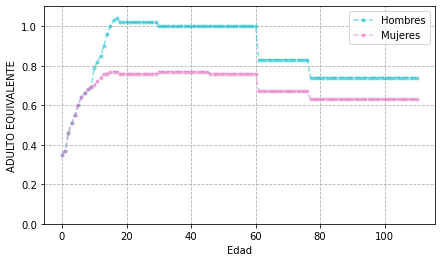

In [36]:
## Adulto Equivalente

fig, axs = plt.subplots(1, figsize = (7, 4))

ad_eq.set_index(['P03', 'P02']).unstack().plot(marker = '.', linestyle = '--', ax = axs, color = ['#17becf', '#e377c2'], alpha = .5)

axs.set_xlabel('Edad')
axs.set_ylabel('ADULTO EQUIVALENTE')
axs.set_ylim(0, 1.1)
axs.grid(linestyle = '--')
axs.legend(['Hombres', 'Mujeres'])
plt.show()

In [4]:
dpto_region = pd.read_csv('./../data/info/DPTO_PROV_Region.csv')
DPTO_Region = radio_ref[['DPTO', 'Region']].drop_duplicates()

if not os.path.exists('./../data/Pobreza/'):
    os.makedirs('./../data/Pobre2za/')

## 1.  Resultados estaticos (se toma 1 año)

In [7]:
import glob
from pathlib import Path    

# path ='./data/RFReg_' # use your path
# path ='./../../encuestador-de-hogares/data/yr_samples/RFReg_' # use your path
path ='./../data/yr_samples/RFReg_'

allFiles = []
for year in [str(s) for s in range(2019, 2021)]:
    allFiles += glob.glob(path +str(frac)+ '*'+str(year)+'*_ARG.csv')
    # Estos son los archivos que se usan para tener una figura estatica, corte donde no importa evol. temporal.

allFiles = sorted(allFiles)[-8:] # ultimo anio
allFiles

[]

In [6]:
# years = np.unique([int(f[-14:-10]) for f in  allFiles])
qstrings = np.unique([Path(allFiles[0]).name.split('_')[-2] for f in  allFiles[-4:]])
ystrings = np.unique([Path(allFiles[0]).name.split('_')[-2].split('-')[0] for f in  allFiles[-4:]])
years = [int(y) for y in ystrings]

if len(years) == 1:
    yr_label = str(years[0])
else:
    yr_label = '-'.join([str(years.min()), str(years.max())])
    
yr_label

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:

df_parts = []
for quarter_Xy_file in sorted(allFiles)[-8:]:# ultimo anio
    df_Q = pd.read_csv(quarter_Xy_file, 
                           usecols = ['PERSONA_REF_ID', 'HOGAR_REF_ID','RADIO_REF_ID', 'CONDACT', 'CAT_INAC', 'CAT_OCUP',
                                      'INGRESO', 'INGRESO_NLB', 'INGRESO_JUB', 'INGRESO_SBS', 'PP07K',
                                      'IX_TOT', 'H16', 'H15','P47T', 'P03','P02', 'P09','P10', 'DPTO', 'URP'])
    
    df_Q['ANO4'] = int(quarter_Xy_file[-18:-14])
    q = quarter_Xy_file[-18:-8]; print(q)
    df_Q['Q'] = q
    df_parts += [df_Q]

df = pd.concat(df_parts)
del df_Q


In [37]:
# import sys

# # These are the usual ipython objects, including this one you are creating
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# # # Get a sorted list of the objects and their sizes
# sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:7]

In [ ]:

columnas_pesos = ['P47T']
df[columnas_pesos] = np.power(10, df[columnas_pesos]) - 1

# Editar columnas
df['P10'] = 2 - df['P10']
df['P09'] = df.P09.replace(5, 4) #Polimodal tomado como secundario 

# df = df.astype(int)
df['P0910'] = df.P09.astype(str) + df.P10.astype(str)
df['Grupo_Etario_3'] = pd.cut(df.P03, np.arange(-1, 80, 3)).astype(str)#.round(-1)
df['Grupo_Etario_INDEC'] = pd.cut(df.P03, np.array([0, 13, 29, 64, 110])).astype(str)#.round(-1)
df['Grupo_Etario_q10'] = pd.cut(df.P03, np.array([-0.001, 5.0,  11.0, 17.0, 23.0, 29.0, 36.0, 44.0, 53.0, 65.0, 110.0])).astype(str)#.round(-1)
# df = pd.read_csv('file.csv', dtype={'Col' : 'category'}) # Despues podemos necesitar...

df = df.reset_index()


### Canasta y Pobreza

In [ ]:
df_cb = df.merge(ad_eq).merge(DPTO_Region).merge(CB_ipc)#.merge(ppp_defl[['Q', 'ppp_5usd_ARS_deflac']])

# df_cb_hogares = df_cb.groupby(['HOGAR_REF_ID', 'Q'])[['P47T','CBA', 'CBT', 'CB_EQUIV', 'ppp_5usd_ARS_deflac']].sum()
df_cb_hogares = df_cb.groupby(['HOGAR_REF_ID', 'Q'])[['P47T','CBA', 'CBT', 'CB_EQUIV']].sum()
del df_cb # Ahorrar memoria

df_cb_hogares['Pobreza'] = df_cb_hogares['P47T'] < df_cb_hogares['CBT']
df_cb_hogares['Indigencia'] = df_cb_hogares['P47T'] < df_cb_hogares['CBA']
# df_cb_hogares['Pobreza_5usd'] = df_cb_hogares['P47T'] < df_cb_hogares['ppp_5usd_ARS_deflac']
# pobreza_hogares = df_cb_hogares[['P47T','CBA','CBT', 'CB_EQUIV','Pobreza', 'Indigencia', 'Pobreza_5usd']].reset_index()
pobreza_hogares = df_cb_hogares[['P47T','CBA','CBT', 'CB_EQUIV','Pobreza', 'Indigencia']].reset_index()
pobreza_hogares['gap_pobreza'] = pobreza_hogares.P47T - pobreza_hogares.CBT
pobreza_hogares['gap_indigencia'] = pobreza_hogares.P47T - pobreza_hogares.CBA
pobreza_hogares = pobreza_hogares.rename(columns = {'P47T': 'P47T_hogar'})

# df = df.sample(25000)
data = df.merge(pobreza_hogares, on = ['HOGAR_REF_ID', 'Q'])#, how = 'left')
del df; del pobreza_hogares # Ahorrar memoria

data = data.rename(columns = {'P47T': 'P47T_persona'})

# data = data
data = data.merge(radio_ref[['RADIO_REF_ID', 'IDFRAC', 'PROV', 'NOMPROV', 'AGLOMERADO', 'Region']].drop_duplicates())

filename = './../data/Pobreza/pobreza_'+'_'.join([str(frac), yr_label])+'.csv'
data.to_csv(filename, index = False)

print(filename+' saved')

In [ ]:
xx

In [ ]:
data[['Pobreza', 'Indigencia', 'Pobreza_5usd']].mean()

In [ ]:
filename

In [ ]:
data.shape

In [ ]:
# # Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)[:7]


## 2. Resultados series de tiempo (se computa para todos y cada trimestre)

In [ ]:
import glob
# path ='./data/RFReg_' # use your path
# path ='./../data/yr_samples/RFReg_' # use your path
# path ='./../../encuestador-de-hogares/data/yr_samples/RFReg_' # use your path
path ='./../../indice-pobreza-ExactasUBA/data/yr_samples/RFReg_' # use your path
path ='./../data/yr_samples/RFReg_'


allFiles = []
for year in [str(s) for s in range(2003, 2021)]: ## Importante poner el anio de comienzo de la serie
    # Estos archivos se computan en la notebook tipo 04c - Predict using trained models- Empleo Trimestral.ipynb
    allFiles += glob.glob(path +str(frac)+'_'+ year +'*.csv')
sorted(allFiles)

In [ ]:
for quarter_Xy_file in sorted(allFiles):
    if not os.path.exists('./../data/Pobreza/'):
        os.makedirs('./../data/Pobreza/')
        
    q = quarter_Xy_file[-18:-8]
    filename = './../data/Pobreza/pobreza_'+'_'.join([str(frac), 'q'+q])+'.csv'
    print(q)
#     if not os.path.exists('./../data/Pobreza/pobreza_'+'_'.join([str(frac), 'q'+q])+'.csv'):

    df = pd.read_csv(quarter_Xy_file, 
                           usecols = ['PERSONA_REF_ID', 'HOGAR_REF_ID','RADIO_REF_ID', 'CONDACT', 'CAT_INAC', 'CAT_OCUP',
                                      'IX_TOT', 'H16', 'H15','P47T', 'P03','P02', 'P09','P10', 'DPTO'])
    df['ANO4'] = int(quarter_Xy_file[-18:-14])
    df['Q'] = q

    columnas_pesos = ['P47T']
    df[columnas_pesos] = np.power(10, df[columnas_pesos]) - 1

#     ddf = dd.from_pandas(df, npartitions=50)
#     with ProgressBar():
#         df = ddf.groupby(['PERSONA_REF_ID']).mean().compute()

    # Editar columnas
    df['P10'] = 2 - df['P10']
    df['P09'] = df.P09.replace(5, 4) #Polimodal tomado como secundario 

#     df = df.astype(int)
    df['P0910'] = df.P09.astype(str) + df.P10.astype(str)
    df['Grupo_Etario_3'] = pd.cut(df.P03, np.arange(-1, 80, 3))#.round(-1)
    df['Grupo_Etario_INDEC'] = pd.cut(df.P03, np.array([0, 13, 29, 64, 110]))#.round(-1)
    df['Grupo_Etario_q10'] = pd.cut(df.P03, np.array([-0.001, 5.0,  11.0, 17.0, 23.0, 29.0, 36.0, 44.0, 53.0, 65.0, 110.0]))#.round(-1)


    df = df.reset_index()

    df_cb = df.merge(ad_eq).merge(DPTO_Region).merge(CB_ipc).merge(ppp_defl[['Q', 'ppp_5usd_ARS_deflac']])

    df_cb_hogares = df_cb.groupby(['HOGAR_REF_ID', 'Q'])[['P47T','CBA', 'CBT', 'CB_EQUIV', 'ppp_5usd_ARS_deflac']].sum()
    df_cb_hogares['Pobreza'] = df_cb_hogares['P47T'] < df_cb_hogares['CBT']
    df_cb_hogares['Indigencia'] = df_cb_hogares['P47T'] < df_cb_hogares['CBA']
    df_cb_hogares['Pobreza_5usd'] = df_cb_hogares['P47T'] < df_cb_hogares['ppp_5usd_ARS_deflac']
    pobreza_hogares = df_cb_hogares[['P47T','CBA','CBT', 'CB_EQUIV','Pobreza', 'Indigencia', 'Pobreza_5usd']].reset_index()
    pobreza_hogares['gap_pobreza'] = pobreza_hogares.P47T - pobreza_hogares.CBT
    pobreza_hogares['gap_indigencia'] = pobreza_hogares.P47T - pobreza_hogares.CBA
    pobreza_hogares = pobreza_hogares.rename(columns = {'P47T': 'P47T_hogar'})

    # df = df.sample(25000)
    data = df.merge(pobreza_hogares, on = ['HOGAR_REF_ID', 'Q'])#, how = 'left')

    data = data.rename(columns = {'P47T': 'P47T_persona'})

    # data = data
    data = data.merge(radio_ref[['RADIO_REF_ID', 'IDFRAC', 'PROV', 'NOMPROV', 'AGLOMERADO', 'Region']].drop_duplicates())

    print("Poblacion: "+str(len(data)/frac))
    display(data[['Pobreza', 'Indigencia', 'Pobreza_5usd']].mean())
    data.to_csv(filename, index = False) ## Aca si ya existen no deberian sobreescribirse (o si)
    
    print(filename+' saved')

In [ ]:
filename

In [ ]:
# ./../data/Pobreza/pobreza_0.02_q2003-08-15.csv

In [ ]:
data.columns

# Distribucion del ingreso

In [ ]:
# import numpy as np
# fig, ax = plt.subplots(1, figsize = (5, 3))
# plt.hist(np.log10(df.loc[df.P47T > 100].P47T).values, 150, normed = 'pdf')#.groupby()
# plt.yscale('log')
# plt.show()

In [ ]:
###### # fig, ax = plt.subplots(1, figsize = (10, 5))
# fig, ax = plt.subplots(1, figsize = (5, 3))
# df_ = df.groupby('HOGAR_REF_ID').sum()#.loc[df.P47T > 100]
# agg = df_.groupby(pd.cut(np.log10(df_.P47T), np.arange(2, 6, .05)))['P47T'].agg(['count','sum'])
# (agg/agg.sum()).plot(ax = ax)
# # ax.set_yscale('log')